<a href="https://colab.research.google.com/github/ToonToonToon/229352-StatisticalLearning/blob/main/229351_LAB08_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ปฏิบัติการครั้งที่ 8

ดาวน์โหลดข้อมูลอุณหภูมิสูงสุดรายวันปี 1998-2019 จาก link ข้างล่างนี้  
https://donlapark.pages.dev/229351/data/CM_temp.csv

1. เปลี่ยนจากข้อมูลรายวันให้เป็นข้อมูลค่าเฉลี่ยรายเดือน
2. จงแบ่งข้อมูลโดยให้ Test set เป็นข้อมูลของ 24 เดือนสุดท้ายและ Training set เป็นข้อมูลก่อนหน้าทั้งหมด
3. ลองสร้างโมเดล Holt-Winters แบบต่างๆ (damped, non-damped, additive, multiplicative etc.) แล้วระบุโมเดลที่ดีที่ให้ค่า RMSE บน test set น้อยที่สุด
4. จงแสดงแผนภาพของข้อมูลจริงกับข้อมูลที่ได้ในข้อ 3

In [1]:
!wget -O CM_temp.csv https://donlapark.pages.dev/229351/data/CM_temp.csv

--2025-09-11 02:23:07--  https://donlapark.pages.dev/229351/data/CM_temp.csv
Resolving donlapark.pages.dev (donlapark.pages.dev)... 172.66.47.56, 172.66.44.200, 2606:4700:310c::ac42:2f38, ...
Connecting to donlapark.pages.dev (donlapark.pages.dev)|172.66.47.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139473 (136K) [text/csv]
Saving to: ‘CM_temp.csv’

CM_temp.csv         100%[===================>] 136.20K  --.-KB/s    in 0.02s   

2025-09-11 02:23:08 (6.25 MB/s) - ‘CM_temp.csv’ saved [139473/139473]



In [2]:
# import module ที่ต้องใช้
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from datetime import datetime

In [3]:
# ฟังก์ชันที่เปลี่ยน string ให้เป็น datetime
def parser(dates):
  return datetime.strptime(dates, '%Y-%m-%d')

# parse_dates ชื่อของคอลัมน์ที่จะเปลี่ยนให้เป็น datetime
# index_col ชื่อของคอลัมน์ที่จะให้เป็น index
# date_parser ฟังก์ชันที่เปลี่ยน string ให้เป็น datetime
data = pd.read_csv('CM_temp.csv', parse_dates=['Date'],
                                        index_col='Date',
                                        date_parser=parser)

data.tail()

/tmp/ipython-input-2705365328.py:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv('CM_temp.csv', parse_dates=['Date'],


,MaxTemp
Date,
2019-07-27,26.2
2019-07-28,34.2
2019-07-29,34.4
2019-07-30,33.5
2019-07-31,30.7


ข้อมูลที่ได้เป็นข้อมูลรายวัน ทำการหาค่าเฉลี่ยรายเดือนด้วย method `resample`

In [4]:
data_monthly = data['MaxTemp'].resample("M").mean()

data_monthly.head()

/tmp/ipython-input-3219926365.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_monthly = data['MaxTemp'].resample("M").mean()


,MaxTemp
Date,
1998-01-31,31.687097
1998-02-28,33.685714
1998-03-31,37.103226
1998-04-30,37.910000
1998-05-31,35.848387


In [5]:
def rmse(y_true,y_pred):
  # Inputs
  # y_true: actual value, y_pred: predicted values
  # Output: RMSE between y_true and y_pred
  return np.sqrt(np.mean(np.square(y_true-y_pred)))

In [11]:
y = data_monthly
train = y[:-24]
test = y[-24:]
print(f"Training set size: {len(train)}")
print(f"Test set size: {len(test)}")
print("\nLast 3 months of training data:")
print(train.tail(3))
print("\nFirst 3 months of test data:")
print(test.head(3))

Training set size: 235
Test set size: 24

Last 3 months of training data:
Date
2017-05-31    34.806452
2017-06-30    33.523333
2017-07-31    32.361290
Freq: ME, Name: MaxTemp, dtype: float64

First 3 months of test data:
Date
2017-08-31    32.764516
2017-09-30    33.140000
2017-10-31    32.158065
Freq: ME, Name: MaxTemp, dtype: float64


In [12]:
#Additive Model
hw_add = ExponentialSmoothing(
    train,
    trend='add',
    seasonal='add',
    seasonal_periods=12
).fit()
pred_add = hw_add.predict(start=test.index[0], end=test.index[-1])
rmse_add = rmse(test, pred_add)
print(f'RMSE of Additive Model: {rmse_add:.4f}')

#Multiplicative Model
hw_mul = ExponentialSmoothing(
    train,
    trend='mul',
    seasonal='mul',
    seasonal_periods=12
).fit()
pred_mul = hw_mul.predict(start=test.index[0], end=test.index[-1])
rmse_mul = rmse(test, pred_mul)
print(f'RMSE of Multiplicative Model: {rmse_mul:.4f}')

#Damped Additive Model
hw_add_damped = ExponentialSmoothing(
    train,
    trend='add',
    seasonal='add',
    damped_trend=True,
    seasonal_periods=12
).fit()
pred_add_damped = hw_add_damped.predict(start=test.index[0], end=test.index[-1])
rmse_add_damped = rmse(test, pred_add_damped)
print(f'RMSE of Damped Additive Model: {rmse_add_damped:.4f}')

#Damped Multiplicative Model
hw_mul_damped = ExponentialSmoothing(
    train,
    trend='mul',
    seasonal='mul',
    damped_trend=True,
    seasonal_periods=12
).fit()
pred_mul_damped = hw_mul_damped.predict(start=test.index[0], end=test.index[-1])
rmse_mul_damped = rmse(test, pred_mul_damped)
print(f'RMSE of Damped Multiplicative Model: {rmse_mul_damped:.4f}')

RMSE of Additive Model: 1.1670
RMSE of Multiplicative Model: 1.1824
RMSE of Damped Additive Model: 1.1135
RMSE of Damped Multiplicative Model: 1.1064


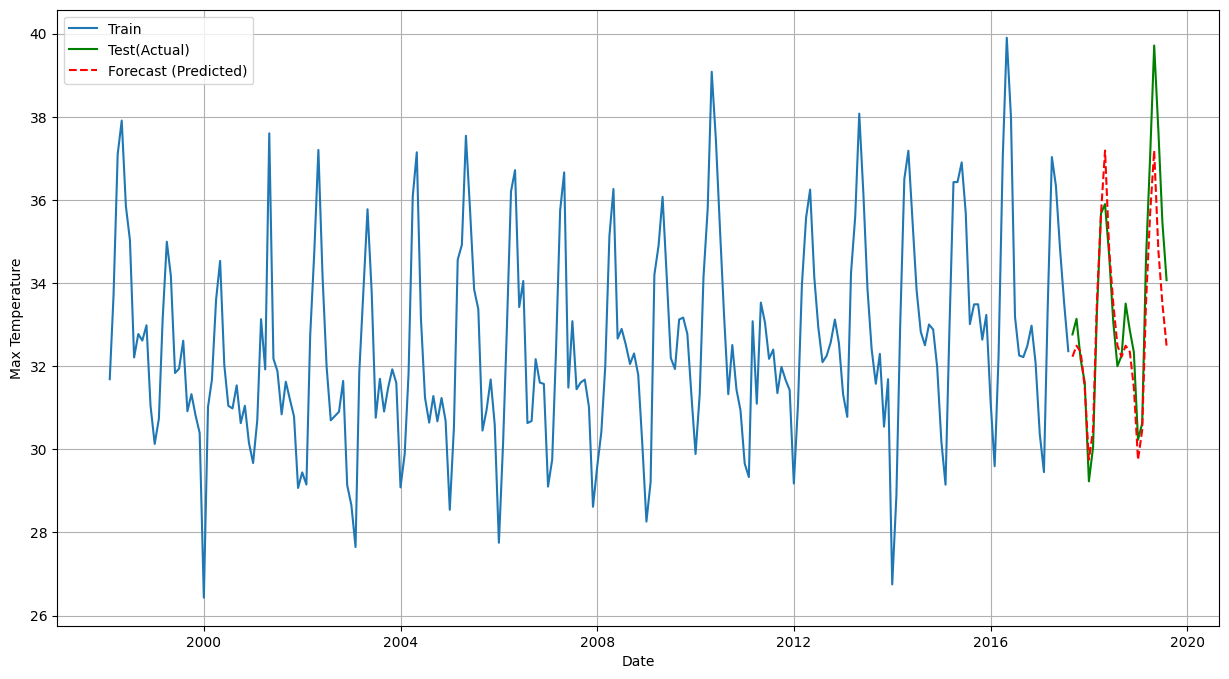

In [14]:
#RMSE of Damped Multiplicative Model: 1.1064
import matplotlib.pyplot as plt
best_prediction = pred_add_damped
plt.figure(figsize=(15, 8))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test(Actual)', color='green')
plt.plot(best_prediction.index, best_prediction, label='Forecast (Predicted)', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Max Temperature')
plt.legend()
plt.grid(True)
plt.show()